### Task 3: Feature Engineering

In this task, feature engineering will involve several key steps. First, aggregate features will be created by calculating metrics such as total, average, count, and standard deviation of transaction amounts for each customer. Then, new time-based features such as transaction hour, day, month, and year will be extracted from the data. Next, categorical variables will be encoded into numerical formats using One-Hot or Label Encoding. Missing values will be handled either by imputation (using mean, median, mode, or advanced methods like KNN) or removal. Numerical features will be normalized or standardized for consistency. Finally, Weight of Evidence (WoE) binning will be applied to classify users as high-risk or low-risk based on their RFMS score, which will help in constructing a credit scoring system.

In [220]:
# Load the dataset 
import pandas as pd 
df = pd.read_csv("../notebooks/data/cleaned_dataset.csv")
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0
4,TransactionId_23223,BatchId_25954,AccountId_1078,SubscriptionId_4238,CustomerId_1432,UGX,256,ProviderId_6,ProductId_3,airtime,ChannelId_3,2000.0,2000,2018-11-15T03:35:10Z,2,0


In [221]:
df.columns.tolist()

['TransactionId',
 'BatchId',
 'AccountId',
 'SubscriptionId',
 'CustomerId',
 'CurrencyCode',
 'CountryCode',
 'ProviderId',
 'ProductId',
 'ProductCategory',
 'ChannelId',
 'Amount',
 'Value',
 'TransactionStartTime',
 'PricingStrategy',
 'FraudResult']

In [222]:
for col in df.columns:
    unique_values = df[col].unique()
    print(f"Unique values in column '{col}':")
    print(unique_values)
    print(f"Total unique values: {len(unique_values)}")
    print("-" * 50)

Unique values in column 'TransactionId':
['TransactionId_76871' 'TransactionId_73770' 'TransactionId_26203' ...
 'TransactionId_82501' 'TransactionId_136354' 'TransactionId_35670']
Total unique values: 69960
--------------------------------------------------
Unique values in column 'BatchId':
['BatchId_36123' 'BatchId_15642' 'BatchId_53941' ... 'BatchId_118602'
 'BatchId_70924' 'BatchId_29317']
Total unique values: 69418
--------------------------------------------------
Unique values in column 'AccountId':
['AccountId_3957' 'AccountId_4841' 'AccountId_4229' ... 'AccountId_2690'
 'AccountId_1731' 'AccountId_1685']
Total unique values: 2908
--------------------------------------------------
Unique values in column 'SubscriptionId':
['SubscriptionId_887' 'SubscriptionId_3829' 'SubscriptionId_222' ...
 'SubscriptionId_656' 'SubscriptionId_3306' 'SubscriptionId_84']
Total unique values: 2903
--------------------------------------------------
Unique values in column 'CustomerId':
['Customer

##### Creation of Aggregate features

In [223]:
import pandas as pd

# Group by 'CustomerId' and create the aggregate features
df_aggregate = df.groupby('CustomerId').agg(
    Total_Transaction_Amount=('Value', 'sum'),          # Sum of all transactions
    Average_Transaction_Amount=('Value', 'mean'),       # Average transaction amount
    Transaction_Count=('Value', 'count'),               # Number of transactions
    Std_Transaction_Amount=('Value', 'std')             # Standard deviation of transaction amounts
).reset_index()

# Since the aggregate columns are already correctly named, you can just work with the DataFrame as-is.
# If you need to reassign or work with these columns explicitly, you can access them like this:
total_transaction_amount = df_aggregate['Total_Transaction_Amount']
average_transaction_amount = df_aggregate['Average_Transaction_Amount']
transaction_count = df_aggregate['Transaction_Count']
std_transaction_amount = df_aggregate['Std_Transaction_Amount']

# Calculate the median of the standard deviation (ignoring NaNs)
std_median = df_aggregate['Std_Transaction_Amount'].median()

# Impute missing standard deviation values with the median
df_aggregate['Std_Transaction_Amount'] = df_aggregate['Std_Transaction_Amount'].fillna(std_median)

# Display the result
print(df_aggregate.head(10))

# Display the shape of the DataFrame
df_aggregate.shape


        CustomerId  Total_Transaction_Amount  Average_Transaction_Amount  \
0  CustomerId_1001                       200                  200.000000   
1  CustomerId_1002                      4775                  434.090909   
2  CustomerId_1003                      7000                 2333.333333   
3  CustomerId_1004                      2000                 2000.000000   
4  CustomerId_1005                      6200                 2066.666667   
5  CustomerId_1006                      1000                 1000.000000   
6  CustomerId_1009                       500                  500.000000   
7  CustomerId_1010                      2665                  666.250000   
8  CustomerId_1012                     92894                 1290.194444   
9  CustomerId_1014                      3000                 1000.000000   

   Transaction_Count  Std_Transaction_Amount  
0                  1             1141.677114  
1                 11              518.805446  
2                  3  

(3395, 5)

#### Next we proceed into extracting features(Time of transaction)

In [224]:
import pandas as pd

# Convert 'TransactionStartTime' to a datetime object for easier manipulation
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], format='%Y-%m-%dT%H:%M:%SZ')

# Extract the required features from 'TransactionStartTime'
df['Transaction_Hour'] = df['TransactionStartTime'].dt.hour      # Hour of the transaction
df['Transaction_Day'] = df['TransactionStartTime'].dt.day        # Day of the month
df['Transaction_Month'] = df['TransactionStartTime'].dt.month    # Month of the year
df['Transaction_Year'] = df['TransactionStartTime'].dt.year      # Year of the transaction

# Display the updated DataFrame with the new features
print(df.head())


         TransactionId        BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871  BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770  BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203  BatchId_53941  AccountId_4229   SubscriptionId_222   
3  TransactionId_28195  BatchId_38780  AccountId_4841  SubscriptionId_3829   
4  TransactionId_23223  BatchId_25954  AccountId_1078  SubscriptionId_4238   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   
4  CustomerId_1432          UGX          256  ProviderId_6   ProductId_3   

      ProductCategory    ChannelId  Amount  Value TransactionStartTime  \


Next we are going to proceed with encoding categorical variables.

In [225]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define mappings for One-Hot Encoding directly
provider_mapping = {
    'ProviderId_1': 1,
    'ProviderId_2': 2,
    'ProviderId_3': 3,
    'ProviderId_4': 4,
    'ProviderId_5': 5,
    'ProviderId_6': 6
}

product_mapping = {
    'ProductId_1': 1,
    'ProductId_2': 2,
    'ProductId_3': 3,
    'ProductId_4': 4,
    'ProductId_6': 6,
    'ProductId_10': 10,
    'ProductId_11': 11,
    'ProductId_12': 12,
    'ProductId_13': 13,
    'ProductId_14': 14,
    'ProductId_15': 15,
    'ProductId_16': 16,
    'ProductId_19': 19,
    'ProductId_20': 20,
    'ProductId_21': 21,
    'ProductId_22': 22,
    'ProductId_24': 24,
    'ProductId_9': 9
}

channel_mapping = {
    'ChannelId_1': 1,
    'ChannelId_2': 2,
    'ChannelId_3': 3,
    'ChannelId_5': 5
}

# Apply the mappings to replace the original values in the DataFrame
df['ProviderId'] = df['ProviderId'].map(provider_mapping)
df['ProductId'] = df['ProductId'].map(product_mapping)
df['ChannelId'] = df['ChannelId'].map(channel_mapping)

# Apply Label Encoding for ProductCategory
label_encoder = LabelEncoder()
df['ProductCategory'] = label_encoder.fit_transform(df['ProductCategory'])

# Display only the columns where encoding was applied
encoded_columns = ['ProviderId', 'ProductId', 'ChannelId', 'ProductCategory']
print(df[encoded_columns].head())




   ProviderId  ProductId  ChannelId  ProductCategory
0           6         10          3                0
1           4          6          2                2
2           6          1          3                0
3           4          6          2                2
4           6          3          3                0


# Meta Data Description

## Encoding Metadata

### One-Hot Encoding:
- ProviderId:
  - ProviderId_1 -> 1
  - ProviderId_2 -> 2
  - ProviderId_3 -> 3
  - ProviderId_4 -> 4
  - ProviderId_5 -> 5
  - ProviderId_6 -> 6

- ProductId:
  - ProductId_1 -> 1
  - ProductId_2 -> 2
  - ProductId_3 -> 3
  - ProductId_4 -> 4
  - ProductId_6 -> 6
  - ProductId_10 -> 10
  - ProductId_11 -> 11
  - ProductId_12 -> 12
  - ProductId_13 -> 13
  - ProductId_14 -> 14
  - ProductId_15 -> 15
  - ProductId_16 -> 16
  - ProductId_19 -> 19
  - ProductId_20 -> 20
  - ProductId_21 -> 21
  - ProductId_22 -> 22
  - ProductId_24 -> 24
  - ProductId_9 -> 9

- ChannelId:
  - ChannelId_1 -> 1
  - ChannelId_2 -> 2
  - ChannelId_3 -> 3
  - ChannelId_5 -> 5

### Label Encoding:
- ProductCategory:
  - airtime -> 0
  - financial_services -> 1
  - data_bundles -> 2
  - tv -> 3
  - utility_bill -> 4
  - movies -> 5
  - other -> 6
  - ticket -> 7

#### Looking for missing values and fixing them using Imputation or removal.

In [226]:
for col in df.columns:
    print(f"Column: {col}, Data type: {df[col].dtype}")

Column: TransactionId, Data type: object
Column: BatchId, Data type: object
Column: AccountId, Data type: object
Column: SubscriptionId, Data type: object
Column: CustomerId, Data type: object
Column: CurrencyCode, Data type: object
Column: CountryCode, Data type: int64
Column: ProviderId, Data type: int64
Column: ProductId, Data type: int64
Column: ProductCategory, Data type: int64
Column: ChannelId, Data type: int64
Column: Amount, Data type: float64
Column: Value, Data type: int64
Column: TransactionStartTime, Data type: datetime64[ns]
Column: PricingStrategy, Data type: int64
Column: FraudResult, Data type: int64
Column: Transaction_Hour, Data type: int32
Column: Transaction_Day, Data type: int32
Column: Transaction_Month, Data type: int32
Column: Transaction_Year, Data type: int32


In [227]:
# Define columns with categorical values and encoded columns
categorical_columns = ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 
                       'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'FraudResult']
encoded_columns = ['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId']

# Fill missing values with mode for categorical and encoded columns
for col in categorical_columns + encoded_columns:
    mode_value = df[col].mode()[0]  # Get the mode of the column
    df[col] = df[col].fillna(mode_value)  # Replace NaN values with mode

# Define columns with numerical values
numerical_columns = ['CountryCode', 'Amount', 'Value', 'PricingStrategy', 'Transaction_Hour', 
                     'Transaction_Day', 'Transaction_Month', 'Transaction_Year']

# Fill missing values with median for numerical columns
for col in numerical_columns:
    median_value = df[col].median()  # Get the median of the column
    df[col] = df[col].fillna(median_value)  # Replace NaN values with median

# Handle datetime columns separately
df['TransactionStartTime'] = df['TransactionStartTime'].fillna(df['TransactionStartTime'].mode()[0])

# Verify if missing values are handled
print(df.isnull().sum())


TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
Transaction_Hour        0
Transaction_Day         0
Transaction_Month       0
Transaction_Year        0
dtype: int64


In [228]:
print(df_aggregate.head(15))

         CustomerId  Total_Transaction_Amount  Average_Transaction_Amount  \
0   CustomerId_1001                       200                  200.000000   
1   CustomerId_1002                      4775                  434.090909   
2   CustomerId_1003                      7000                 2333.333333   
3   CustomerId_1004                      2000                 2000.000000   
4   CustomerId_1005                      6200                 2066.666667   
5   CustomerId_1006                      1000                 1000.000000   
6   CustomerId_1009                       500                  500.000000   
7   CustomerId_1010                      2665                  666.250000   
8   CustomerId_1012                     92894                 1290.194444   
9   CustomerId_1014                      3000                 1000.000000   
10  CustomerId_1016                      1000                 1000.000000   
11  CustomerId_1020                    141105                  766.875000   

Next we are going to apply the same cleaning of missing values for the data frame which was aggregated preciously.

In [229]:
import pandas as pd

# df_aggregate contains: 'CustomerId' (categorical), and numerical columns: 'Total_Transaction_Amount', 'Average_Transaction_Amount', 'Transaction_Count', 'Std_Transaction_Amount'

# Replace missing values for categorical columns with mode
df_aggregate['CustomerId'] = df_aggregate['CustomerId'].fillna(df_aggregate['CustomerId'].mode()[0])

# Replace missing values for numerical columns with median
numerical_columns = ['Total_Transaction_Amount', 'Average_Transaction_Amount', 'Transaction_Count', 'Std_Transaction_Amount']
for col in numerical_columns:
    df_aggregate[col] = df_aggregate[col].fillna(df_aggregate[col].median())

# Verify missing values are handled
print(df_aggregate.isnull().sum())


CustomerId                    0
Total_Transaction_Amount      0
Average_Transaction_Amount    0
Transaction_Count             0
Std_Transaction_Amount        0
dtype: int64


In [230]:
print(df_aggregate.head(15))

         CustomerId  Total_Transaction_Amount  Average_Transaction_Amount  \
0   CustomerId_1001                       200                  200.000000   
1   CustomerId_1002                      4775                  434.090909   
2   CustomerId_1003                      7000                 2333.333333   
3   CustomerId_1004                      2000                 2000.000000   
4   CustomerId_1005                      6200                 2066.666667   
5   CustomerId_1006                      1000                 1000.000000   
6   CustomerId_1009                       500                  500.000000   
7   CustomerId_1010                      2665                  666.250000   
8   CustomerId_1012                     92894                 1290.194444   
9   CustomerId_1014                      3000                 1000.000000   
10  CustomerId_1016                      1000                 1000.000000   
11  CustomerId_1020                    141105                  766.875000   

#### Next we proceed with the normalization and Standardization of the given columns.

In [231]:
# Import the necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler to normalize values between 0 and 1
scaler = MinMaxScaler()

# List of the column to normalize
numerical_column = ['Value']

# Fit and transform the numerical column
df[numerical_column] = scaler.fit_transform(df[numerical_column])

# Display the 'Value' column after normalization
print(df[['Value']].head())  # Display only the 'Value' column


      Value
0  0.142612
1  0.002572
2  0.071163
3  0.091740
4  0.285510


We also apply the standardization to the aggregate values that we have created earlier.


In [232]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMax scaling to the specified columns
df_aggregate[['Total_Transaction_Amount', 'Average_Transaction_Amount']] = scaler.fit_transform(
    df_aggregate[['Total_Transaction_Amount', 'Average_Transaction_Amount']]
)

# Display the updated DataFrame
print(df_aggregate.head(10))

        CustomerId  Total_Transaction_Amount  Average_Transaction_Amount  \
0  CustomerId_1001                  0.000139                    0.025090   
1  CustomerId_1002                  0.003768                    0.058651   
2  CustomerId_1003                  0.005532                    0.330944   
3  CustomerId_1004                  0.001567                    0.283154   
4  CustomerId_1005                  0.004898                    0.292712   
5  CustomerId_1006                  0.000773                    0.139785   
6  CustomerId_1009                  0.000377                    0.068100   
7  CustomerId_1010                  0.002094                    0.091935   
8  CustomerId_1012                  0.073661                    0.181390   
9  CustomerId_1014                  0.002360                    0.139785   

   Transaction_Count  Std_Transaction_Amount  
0                  1             1141.677114  
1                 11              518.805446  
2                  3  

Now let's merge the two data frames so as to proceed with the RFMS classification and the weight of evidence.

In [233]:
# Set CustomerId as index for both DataFrames
df.set_index('CustomerId', inplace=True)
df_aggregate.set_index('CustomerId', inplace=True)

# Merge the data frames
df_merged = df.join(df_aggregate,how='left')

# Resetting the index so as to keep the column CustomerId as a normal column not as an index.
df_merged.reset_index(inplace=True)

# Display the merged DataFrame
print(df_merged.head(10))

        CustomerId         TransactionId         BatchId       AccountId  \
0  CustomerId_4406   TransactionId_76871   BatchId_36123  AccountId_3957   
1  CustomerId_4406   TransactionId_73770   BatchId_15642  AccountId_4841   
2  CustomerId_4683   TransactionId_26203   BatchId_53941  AccountId_4229   
3   CustomerId_988   TransactionId_28195   BatchId_38780  AccountId_4841   
4  CustomerId_1432   TransactionId_23223   BatchId_25954  AccountId_1078   
5  CustomerId_2858  TransactionId_100640   BatchId_38561  AccountId_4841   
6   CustomerId_598   TransactionId_51905   BatchId_93774   AccountId_272   
7  CustomerId_1053  TransactionId_130161   BatchId_82409   AccountId_710   
8  CustomerId_3052   TransactionId_51800  BatchId_112288  AccountId_2634   
9  CustomerId_3052   TransactionId_33857  BatchId_126394  AccountId_4841   

        SubscriptionId CurrencyCode  CountryCode  ProviderId  ProductId  \
0   SubscriptionId_887          UGX          256           6         10   
1  Subscripti

In [234]:
# Save the newly merged data frame as a .csv file for further analysis
df_merged.to_csv('../notebooks/data/df_merged.csv', index=False)

In [235]:
print(df_merged.columns.tolist())

['CustomerId', 'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'Transaction_Hour', 'Transaction_Day', 'Transaction_Month', 'Transaction_Year', 'Total_Transaction_Amount', 'Average_Transaction_Amount', 'Transaction_Count', 'Std_Transaction_Amount']


#### RFMS Calculation

In [236]:
import pandas as pd

# Sample DataFrame (replace this with your actual DataFrame)
# df_merged = pd.read_csv("your_file.csv")  # Uncomment this line to load your dataset

# Convert transaction date to datetime
df_merged['TransactionDate'] = pd.to_datetime(df_merged['TransactionStartTime'])

# Calculate RFMS features
recency = df_merged.groupby('CustomerId').agg(Recency=('TransactionDate', lambda x: (x.max() - x.min()).days))
frequency = df_merged.groupby('CustomerId').agg(Frequency=('TransactionId', 'count'))
monetary = df_merged.groupby('CustomerId').agg(Monetary=('Average_Transaction_Amount', 'sum'))
size = df_merged.groupby('CustomerId').agg(Size=('Total_Transaction_Amount', 'mean'))  # Assuming 'Value' is what you meant for size

# Combine RFMS features into one DataFrame
rfms_df = pd.concat([recency, frequency, monetary, size], axis=1)

# Reset index to make CustomerId a column again
rfms_df.reset_index(inplace=True)

# Merge RFMS values back to the original DataFrame
df_merged = df_merged.merge(rfms_df, on='CustomerId', how='left')

# Save the updated DataFrame to a CSV file
df_merged.to_csv('../notebooks/data/df_merged.csv', index=False)

# Display the updated DataFrame
print(df_merged.head())


        CustomerId        TransactionId        BatchId       AccountId  \
0  CustomerId_4406  TransactionId_76871  BatchId_36123  AccountId_3957   
1  CustomerId_4406  TransactionId_73770  BatchId_15642  AccountId_4841   
2  CustomerId_4683  TransactionId_26203  BatchId_53941  AccountId_4229   
3   CustomerId_988  TransactionId_28195  BatchId_38780  AccountId_4841   
4  CustomerId_1432  TransactionId_23223  BatchId_25954  AccountId_1078   

        SubscriptionId CurrencyCode  CountryCode  ProviderId  ProductId  \
0   SubscriptionId_887          UGX          256           6         10   
1  SubscriptionId_3829          UGX          256           4          6   
2   SubscriptionId_222          UGX          256           6          1   
3  SubscriptionId_3829          UGX          256           4          6   
4  SubscriptionId_4238          UGX          256           6          3   

   ProductCategory  ...  Transaction_Year  Total_Transaction_Amount  \
0                0  ...          

#### Labeling

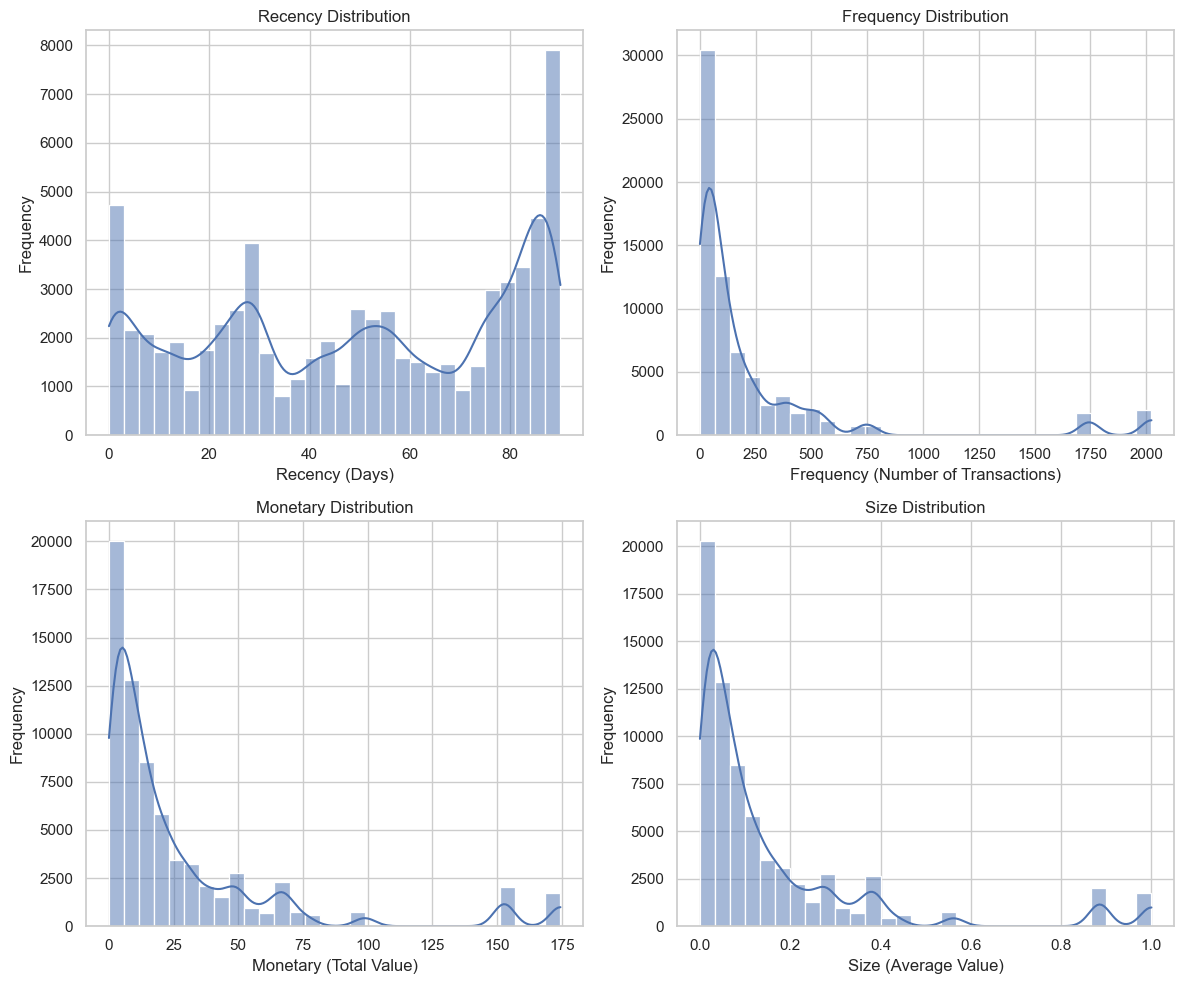

         CustomerId  Recency  Frequency   Monetary      Size Risk_Label
0   CustomerId_4406       86        104  13.537204  0.076935       Good
1   CustomerId_4406       86        104  13.537204  0.076935       Good
2   CustomerId_4683        9          2   0.136201  0.000773        Bad
3    CustomerId_988       79         24   4.066380  0.022953        Bad
4   CustomerId_1432        0          1   0.283154  0.001567        Bad
5   CustomerId_2858       85         20   6.351254  0.035514        Bad
6    CustomerId_598        1          3   0.181362  0.001043        Bad
7   CustomerId_1053        1          7   1.955125  0.010935        Bad
8   CustomerId_3052       28         12   1.545520  0.008769        Bad
9   CustomerId_3052       28         12   1.545520  0.008769        Bad
10  CustomerId_1053        1          7   1.955125  0.010935        Bad
11  CustomerId_1053        1          7   1.955125  0.010935        Bad
12  CustomerId_1053        1          7   1.955125  0.010935    

In [237]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Assuming RFMS values are already calculated and merged into df_merged

# Visualizing RFMS features
plt.figure(figsize=(12, 10))

# Recency Visualization
plt.subplot(2, 2, 1)
sns.histplot(df_merged['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency')

# Frequency Visualization
plt.subplot(2, 2, 2)
sns.histplot(df_merged['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')
plt.xlabel('Frequency (Number of Transactions)')
plt.ylabel('Frequency')

# Monetary Visualization
plt.subplot(2, 2, 3)
sns.histplot(df_merged['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution')
plt.xlabel('Monetary (Total Value)')
plt.ylabel('Frequency')

# Size Visualization
plt.subplot(2, 2, 4)
sns.histplot(df_merged['Size'], bins=30, kde=True)
plt.title('Size Distribution')
plt.xlabel('Size (Average Value)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate thresholds using the median values for classification
recency_threshold = df_merged['Recency'].median()  # Median for Recency
frequency_threshold = df_merged['Frequency'].median()  # Median for Frequency
monetary_threshold = df_merged['Monetary'].median()  # Median for Monetary
size_threshold = df_merged['Size'].median()  # Median for Size

# Establishing the classification rules
def classify_risk(row):
    if (row['Recency'] >= recency_threshold) and \
       (row['Frequency'] >= frequency_threshold) and \
       (row['Monetary'] >= monetary_threshold) and \
       (row['Size'] <= size_threshold):
        return 'Good'
    else:
        return 'Bad'

# Assigning Risk Labels based on the thresholds
df_merged['Risk_Label'] = df_merged.apply(classify_risk, axis=1)

# Save the updated DataFrame to a CSV file
df_merged.to_csv('../notebooks/data/df_merged.csv', index=False)

# Display the first few rows of the updated DataFrame
print(df_merged[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Size', 'Risk_Label']].head(15))


C:\Users\Beab\AppData\Local\Temp\ipykernel_14836\404441866.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_merged, x='Risk_Label', palette='Set2')


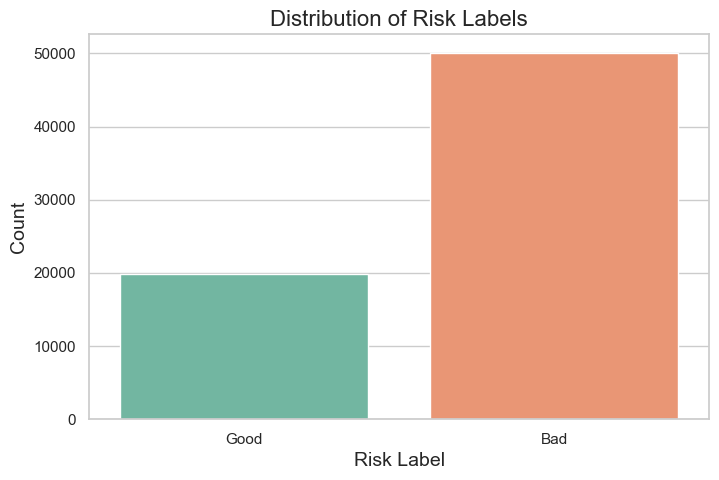

In [238]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with your actual DataFrame)
# df_merged = pd.read_csv("your_file.csv")  # Uncomment this line to load your dataset

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a count plot to visualize the distribution of Risk_Label
plt.figure(figsize=(8, 5))
sns.countplot(data=df_merged, x='Risk_Label', palette='Set2')

# Add title and labels
plt.title('Distribution of Risk Labels', fontsize=16)
plt.xlabel('Risk Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the plot
plt.show()
